#### Imports used

In [13]:
import time

### Input data paths:

# Gioia

In [ ]:
dataset_path = "../../Bio_Project/SimDataset/reads_datasets/all_250000_1.fq"
#classifier_path = "../../Bio_Project/SimDataset/classifiers_results/strex_centrifuge_250000.res"
#classifier_path = "../../Bio_Project/SimDataset/classifiers_results/strex_kraken2_250000.res"
classifier_path = "../../Bio_Project/SimDataset/classifiers_results/strex_clark_genus_250000.res"
clusters_path =  "../../Bio_Project/results/LiME_binning_all_250000_1/all_250000_1+RC.fasta.a16.t20.txt"

IsFasta = False

TotalReassignment = True

# Leo

In [1]:
#dataset_path = "../all_118309_1.fq"
#clusters_path =  "../all_118309_1+RC.fasta.a16.t20.txt"
#classifier_path = "../strex_kraken1_118309.res"

dataset_path = "../all_250000_1.fq"
clusters_path =  "../all_250000_1+RC.fasta.a16.t20.txt"
classifier_path = "../strex_kraken2_250000.res"
#classifier_path = "../strex_centrifuge_250000.res"

IsFasta = False

TotalReassignment = True

#### Load dataset function 
- If dataset is in fasta format then dataset_format parameter equals TRUE.
- If dataset is in fastq format then dataset_format equals FALSE.



In [2]:
def load_dataset(path, datset_format : bool):

    dataset = open(path, "r")
    dataset_lines = []

    if (datset_format):
        divisor = 2
    else:
        divisor = 4

    index = 0
    for line in dataset:
        if (index%divisor==0):
            read_id = line.split()[0]
            dataset_lines.append(read_id[1: len(read_id)-2])
        index = index + 1

    dataset.close()

    return dataset_lines

#### Load clusters result function

In [3]:
def load_clusters_result(path):

    clusters = open(path, "r")
    clusters_list = []

    for group in clusters:
        clusters_list.append(int(group))

    clusters.close()

    return clusters_list

#### Load classifier result function
It returns a dictionary where:

- key = read id
- value = class found by classifier

In [4]:
def load_classifier_result(path):

    classification = open(path, 'r')
    classifier_results = {}

    for line in classification:
        col = []
        for j in range(0, len(line.split())):
            col.append(line.split()[j])
        
        classifier_results[col[0]] = col[1]

    classification.close()

    return classifier_results 

#### Build dataset function
This functions creates a list of following lists:
[read_id, class, cluster]

In [5]:
def build_dataset(dataset_ids,clusters,classifier):
    final_dataset =[]
        
    for i in range(0, len(dataset_ids)):
        final_dataset.append([])

        if dataset_ids[i] in classifier:
            final_dataset[i].append(dataset_ids[i])
            final_dataset[i].append(classifier[dataset_ids[i]])
            final_dataset[i].append(clusters[i])
        else:
            final_dataset[i].append(dataset_ids[i])
            final_dataset[i].append(0)
            final_dataset[i].append(clusters[i])
        
    return final_dataset

#### Get inverted index function
This function is used to create a list for each cluster. This list represents corresponding classes

In [6]:
def get_inverted_index(clusters, dataset):

    num_clusters = max(clusters) + 1
    num_reads = len(dataset)
    inverted_index = []
    
    for i in range(0, num_clusters):
        inverted_index.append([])
   
    for i in range(0, num_reads):
        inverted_index[dataset[i][2]].append(dataset[i][1])

    return inverted_index

#### Find labels function

In [7]:
def find_labels(read_ids, classification_output):

    complete_classifier_result = []
    found : bool = False
    count = 0
    for i in range(0, len(read_ids)):
        for j in range(0, len(classification_output)):
            col = []
            if (read_ids[i] == classification_output[j][0]):
                complete_classifier_result.append(classification_output[j])
                found = True
                break
        if not found:
            count = count +1
            complete_classifier_result.append(read_ids[i], '0')

    print("count: ", count)
    print("length classification output: ", len(classification_output))
    print("length complete classification output: ", len(complete_classifier_result))

    return complete_classifier_result

#### Find labels frequency function
Given a cluster, it returns a dictionary which contains the number of occurency for each class

In [8]:
# dict --> (class, occurences)

def frequency_search(cluster):
    
    label_dict= {}
       
    for label in cluster:         
    
        if label in list(label_dict):
            label_dict[label] = label_dict[label] + 1
        else:
            # if it does not exist, it's automatically created
            label_dict[label] = 1
        
    return label_dict   

#### Basic operation functions
- intersection
- binary search
- diff
- binary search list

In [9]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3


# Iterative Binary Search Function
# It returns index of x in given array arr if present,
# else returns -1
def binary_search(arr, x):
    low = 0
    high = len(arr) - 1
    mid = 0
    while low <= high:
        mid = (high + low) // 2
        # If x is greater, ignore left half
        if arr[mid] < x:
            low = mid + 1
        # If x is smaller, ignore right half
        elif arr[mid] > x:
            high = mid - 1
        # means x is present at mid
        else:
            return mid
    # If we reach here, then the element was not present
    return -1


# Python code t get difference of two lists
# Not using set()
def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

# Iterative Binary Search Function
# It returns index of x in given array arr if present,
# else returns -1
def binary_search_list(arr, x):
    low = 0
    high = len(arr) - 1
    mid = 0
    while low <= high:
        mid = (high + low) // 2
        #print(arr[mid][0])
        # If x is greater, ignore left half
        if arr[mid][0] < x:
            low = mid + 1
        # If x is smaller, ignore right half
        elif arr[mid][0] > x:
            high = mid - 1
        # means x is present at mid
        else:
            return mid
    # If we reach here, then the element was not present
    return -1

#### Reassignment functions
1)The first function substitutes every cluster's element (class) with the most the most numerous class
2)The second one substitutes only missclassified elements with the most numerous

In [10]:
def total_reassignment(dataset, max_labels):

    reassigned_classification = []

    for i in range(0, len(dataset)):
        cluster_index = dataset[i][2]
        reassigned_classification.append([dataset[i][0], max_labels[cluster_index]])
                                          
    return reassigned_classification

In [11]:
def partial_reassignment(dataset, max_labels):

    reassigned_classification = []

    for i in range(0, len(dataset)):
        cluster_index = dataset[i][2]
        if (dataset[i][1] == '0' or  dataset[i][1] == 0):
            reassigned_classification.append([dataset[i][0], max_labels[cluster_index]])
        else:
            reassigned_classification.append([dataset[i][0], dataset[i][1]])
                                          
    return reassigned_classification

## Main code

In [14]:
start = time.time()

dataset_lines = load_dataset(dataset_path, IsFasta)
clusters_list = load_clusters_result(clusters_path)
classifier_results = load_classifier_result(classifier_path)

#new Structure : id , classifier result , cluster

dataset = build_dataset(dataset_lines,clusters_list,classifier_results)

stop = time.time()

print("Files loaded and datasets created in time: ", stop-start)



if (len(dataset_lines) == len(clusters_list)):
    num_reads = len(dataset_lines)
else:
    print ("Error in input files!")
    exit()


    
# INVERTED INDEX

start = time.time()

inverted_index = get_inverted_index(clusters_list, dataset)

stop = time.time()

print("Inverted index created in time: ", stop-start)
    
    
start = time.time()
i = 0
max_label_per_cluster_list = []
max_label_list = []
for cluster in inverted_index:
    label_dict = frequency_search(cluster)
    max_label = ""
    max_count = 0
    for label, count in label_dict.items():
        #print(label, count)
        if (count > max_count):
            max_count = count
            max_label = label
    #print("CLUSTER: ", i, " MAX_LABEL: ", max_label, "MAX COUNT: ", max_count, "CLUSTER LENGTH: ", len(cluster))
    max_label_list.append(max_label)
    max_label_per_cluster_list.append([max_label, max_count, len(cluster)])
    i = i + 1

    
#Choose the type of reassignment
if TotalReassignment:
    reassigned_classification = total_reassignment(dataset, max_label_list) 
else:
    reassigned_classification = partial_reassignment(dataset, max_label_list) 
stop = time.time()


print("Classes have been elaborated in: ", stop-start)

Files loaded and datasets created in time:  13.303314924240112
Inverted index created in time:  1.1154060363769531
Classes have been elaborated in:  4.88317084312439


### Saving results

In [17]:
dataset_path = "../../Bio_Project/SimDataset/reads_datasets/all_250000_1.fq"
classifier_path = "../../Bio_Project/SimDataset/classifiers_results/strex_clark_genus_250000.res"


starting_point = 0
end_point = 0

for i in range(len(dataset_path)):
    if dataset_path[i] == '/':
        starting_point = i+1

outputfile = dataset_path[starting_point:len(dataset_path)]
    

for i in range(len(classifier_path)):
    if classifier_path[i] == '/':
        starting_point = i+1
        
for i in range(len(classifier_path)):
    if classifier_path[len(classifier_path)-i -1] == '.':
        end_point = len(classifier_path) - i-2
        break

outputfile = outputfile + '_' +classifier_path[starting_point:end_point]

if TotalReassignment:
    outputfile = outputfile + ".totalReassignment.res"
else:
    outputfile = outputfile + ".partialReassignment.res"


f = open(outputfile, "w")

for element in reassigned_classification:
    f.write(element[0])
    f.write("\t")
    f.write(str(element[1]))
    f.write("\n")
f.close()

print("File ",outputfile ," created.")

print("Done")

File  all_250000_1.fq_strex_clark_genus_25000.totalReassignment.res  created.
Done


### Analysis tests 

In [18]:
import matplotlib.pyplot as plt

print(max_label_per_cluster_list[i])



['76759', 3, 3]


In [19]:
top = 15

# more numerous clusters

#number of total read in the cluster
topTotalMax = [0]*top
#higher number of equal element in the cluster
topEqualMax = [0]*top
#class of the higher number of equal element
topClusterMax = ['0']*top
topI = [0]*top

for i in range(len(max_label_per_cluster_list)):
    for j in range(len(topTotalMax)):
        if topTotalMax[j] < max_label_per_cluster_list[i][2]:
            topTotalMax[j] = max_label_per_cluster_list[i][2]
            topEqualMax[j] = max_label_per_cluster_list[i][1]
            topClusterMax[j] = max_label_per_cluster_list[i][0]
            topI[j] = str(i)
            break


print(topI)     
print(topClusterMax)     
print(topEqualMax)
print(topTotalMax)


['540108', '735195', '735196', '735197', '735198', '735199', '735200', '735201', '735202', '735203', '692131', '571502', '571602', '682214', '571567']
['0', '0', '0', '569195', '11809', '37138', '1623295', '85106', '259898', '1925779', '1351', '2100', '2100', '487', '2100']
[54205, 60238, 56797, 37588, 20095, 30070, 55834, 33354, 18713, 22161, 182, 312, 290, 173, 241]
[62921, 62500, 62500, 62500, 62500, 62500, 62500, 62500, 62500, 62500, 355, 312, 300, 282, 273]


Text(0.5, 1.0, 'Top 15 more numerous clusters')

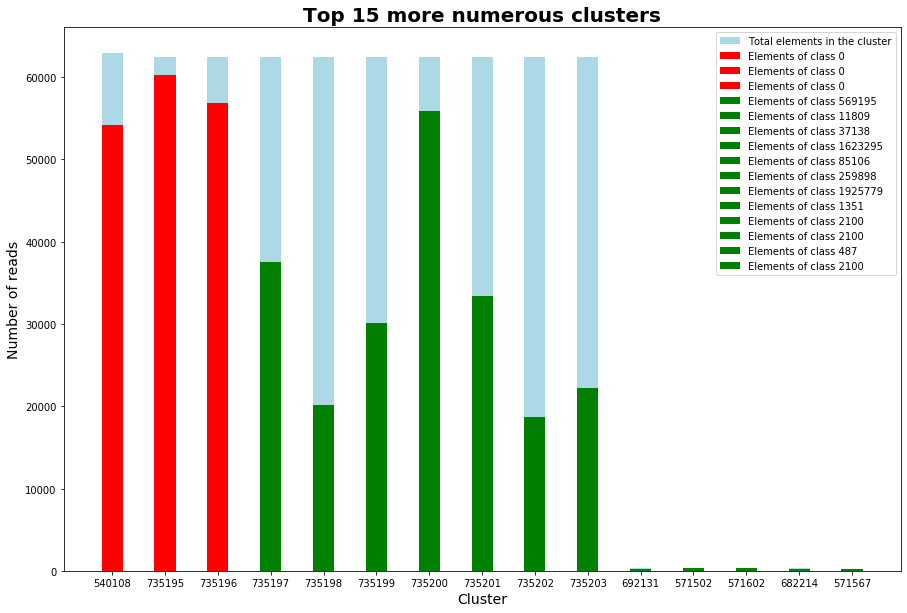

In [20]:
plt.figure(figsize=(15,10))

width = 0.4

plt.bar(topI,topTotalMax,width=width,color='lightblue',label='Total elements in the cluster')
for i in range(len(topClusterMax)):
    name = 'Elements of class ' + str(topClusterMax[i])
    if topClusterMax[i] == '0':
        plt.bar(topI[i],topEqualMax[i],width=width,alpha=1,color='red',label=name)
    else:
        plt.bar(topI[i],topEqualMax[i],width=width,alpha=1,color='green',label=name)

plt.xlabel('Cluster',fontsize=14)
plt.ylabel('Number of reads',fontsize=14)
#plt.xticks([topClusterMax[i] for i in range(len(topClusterMax))])
plt.legend(loc='upper right')
plt.title('Top ' + str(top) + ' more numerous clusters',fontweight='bold',fontsize=20)